In [1]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt

# load functions
from functions.feature_engineering import *

In [2]:
# set some colors
spotify_green = "#1DB954"
spotify_black = "#191414"

In [3]:
# read in data
artists, tracks = get_data(
    audio_path="../../data/spotify_audio_features.json",
    artists_path="../../data/spotify_artists.json",
    playlists_path="../../data/spotify_top_50_playlists.json",
)

In [43]:
# pick some markets
markets = {
    "usa": "United States",
    "japan": "Japan",
    "nigeria": "Nigeria",
    "argentina": "Argentina",
}

In [53]:
# function look at distribution of audio features
def plot_audio_feature_distr(fig, axs, tracks, markets, audio_feature, scale_by_100=True, zero_100_axis=True):
    for i, market in enumerate(markets):
        market_data = tracks[tracks["market_id"] == market]

        axs[i].grid(axis="y", alpha=0.2)
        if scale_by_100:
            axs[i].hist(
                market_data[audio_feature] * 100,
                rwidth=1,
                edgecolor=spotify_black,
                color=spotify_green,
                linewidth=2.5,
            )
        else:
            axs[i].hist(
                market_data[audio_feature],
                rwidth=1,
                edgecolor=spotify_black,
                color=spotify_green,
                linewidth=2.5,
            )

        # remove all underscores from audio_feature and make title case
        audio_feature_title = audio_feature.replace("_", " ").title()

        # make audio feature title case
        axs[i].set_xlabel(audio_feature_title + " Rating")
        axs[i].set_ylabel("# of Tracks")
        axs[i].set_title(
            f"Distribution of {audio_feature_title} Ratings - {markets[market]}", fontweight="bold", fontsize=9
        )
        if zero_100_axis:
            axs[i].set_xticks(range(0, 101, 10))
        axs[i].spines["top"].set_visible(False)
        axs[i].spines["right"].set_visible(False)
        axs[i].spines["bottom"].set_visible(False)
        axs[i].spines["left"].set_visible(False)

    plt.tight_layout()
    plt.show()

### Energy Plot


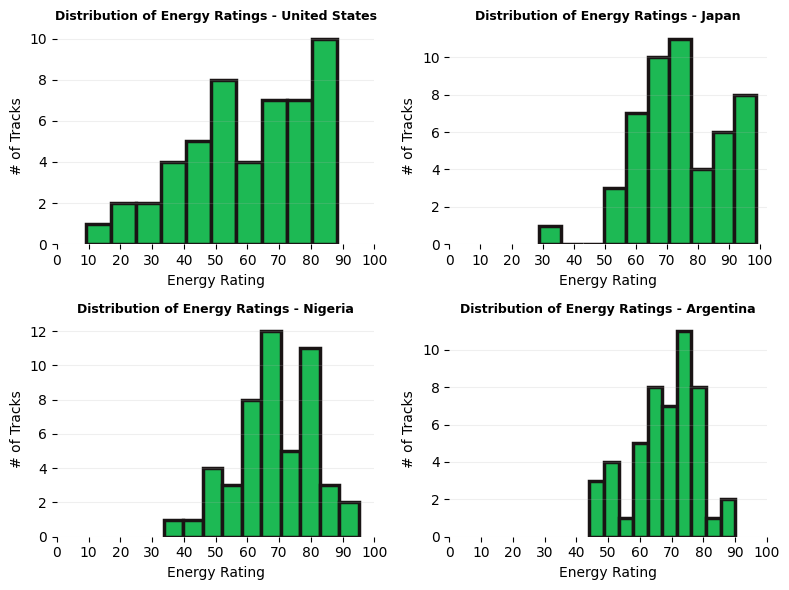

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()
plot_audio_feature_distr(
    fig=fig,
    axs=axs,
    tracks=tracks,
    markets=markets,
    audio_feature="energy",
)

### Acousticness Plot


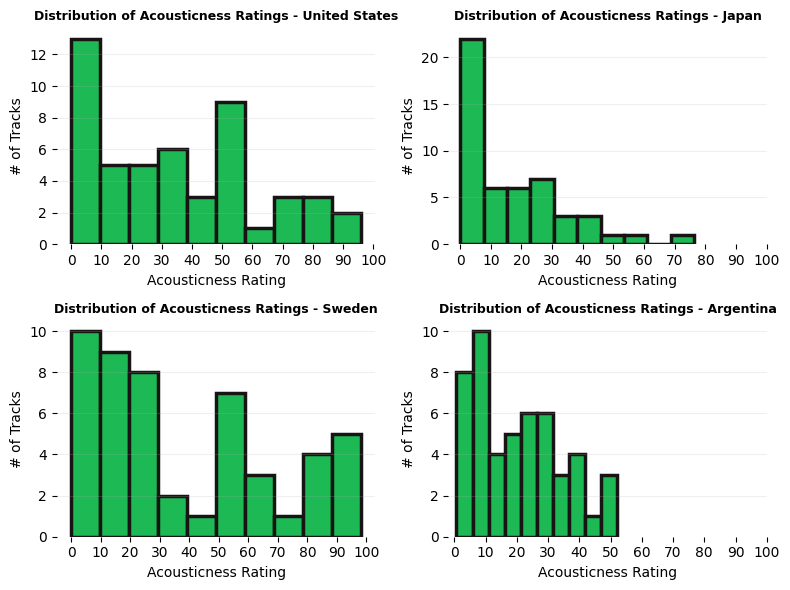

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()

markets = {
    "usa": "United States",
    "japan": "Japan",
    "sweden": "Sweden",
    "argentina": "Argentina",
}

plot_audio_feature_distr(
    fig=fig,
    axs=axs,
    tracks=tracks,
    markets=markets,
    audio_feature="acousticness",
)

### Valence Plot


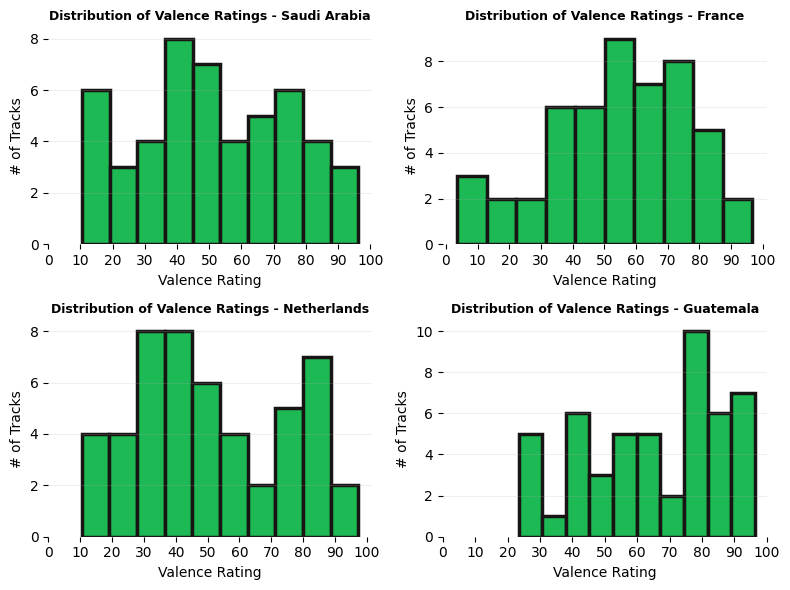

In [63]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.ravel()

markets = {
    "saudi_arabia": "Saudi Arabia",
    "france": "France",
    "netherlands": "Netherlands",
    "guatemala": "Guatemala",
}

plot_audio_feature_distr(
    fig=fig,
    axs=axs,
    tracks=tracks,
    markets=markets,
    audio_feature="valence",
)